# Montage de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import des librairies

In [ ]:
import cv2

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

from PIL import Image

import random

import seaborn as sns

import shutil

import time,datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from torchsummary import summary

from tqdm.autonotebook import tqdm

import sklearn.metrics as metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Téléchargement et extraction des données

In [ ]:
!wget https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/download

# !cp /content/drive/MyDrive/Artificial_Intelligence/covid19_detector/archive.zip /content/
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# Préparation des données d'entrainement, de validation et de test

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal/images', 'Viral Pneumonia/images', 'COVID/images']

test_ratio = 0.2
val_ratio = 0.1

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir('covid19_dataset')
    os.mkdir(os.path.join('covid19_dataset', 'train'))
    os.mkdir(os.path.join('covid19_dataset', 'val'))
    os.mkdir(os.path.join('covid19_dataset', 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join('covid19_dataset', 'train',  class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join('covid19_dataset', 'test', c))
        os.mkdir(os.path.join('covid19_dataset', 'val', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join('covid19_dataset', 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images)*test_ratio))
        for image in selected_images:
            source_path = os.path.join('covid19_dataset', 'train', c, image)
            target_path = os.path.join('covid19_dataset', 'test', c, image)
            shutil.move(source_path, target_path)
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join('covid19_dataset', 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images)*val_ratio))
        for image in selected_images:
            source_path = os.path.join('covid19_dataset', 'train', c, image)
            target_path = os.path.join('covid19_dataset', 'val', c, image)
            shutil.move(source_path, target_path) 

root_dir = 'covid19_dataset'

# Création de la classe de Dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names =  ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        img = Image.open(image_path).convert('RGB')
        # Converting from PIL image to numpy array
        data = np.asarray(img)
        # Performing a Contrast Stretching in each image from the Dataset
        hist,bins = np.histogram(data.flatten(),256,[0,256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()
        cdf_m = np.ma.masked_equal(cdf,0)
        cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m,0).astype('uint8')
        # Converting back to PIL image
        image = Image.fromarray(cdf[img])
        
        return self.transform(image), self.class_names.index(class_name)

# Transformation et augmentation des images

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Préparation des DataLoader

In [ ]:
train_path = os.path.join(root_dir, 'train')

train_dirs = {
    'normal': os.path.join(train_path, 'normal'),
    'viral': os.path.join(train_path, 'viral'),
    'covid': os.path.join(train_path, 'covid')
}

train_dataset = CustomDataset(train_dirs, train_transform)

Found 7339 normal examples
Found 969 viral examples
Found 2604 covid examples


In [ ]:
val_path = os.path.join(root_dir, 'val')

val_dirs = {
    'normal': os.path.join(val_path, 'normal'),
    'viral': os.path.join(val_path, 'viral'),
    'covid': os.path.join(val_path, 'covid')
}

val_dataset = CustomDataset(val_dirs, val_transform)

Found 815 normal examples
Found 107 viral examples
Found 289 covid examples


In [ ]:
test_path = os.path.join(root_dir, 'test')

test_dirs = {
    'normal': os.path.join(test_path, 'normal'),
    'viral': os.path.join(test_path, 'viral'),
    'covid': os.path.join(test_path, 'covid')
}

test_dataset = CustomDataset(test_dirs, test_transform)

Found 2038 normal examples
Found 269 viral examples
Found 723 covid examples


In [ ]:
batch_size = 64

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Distribution des données

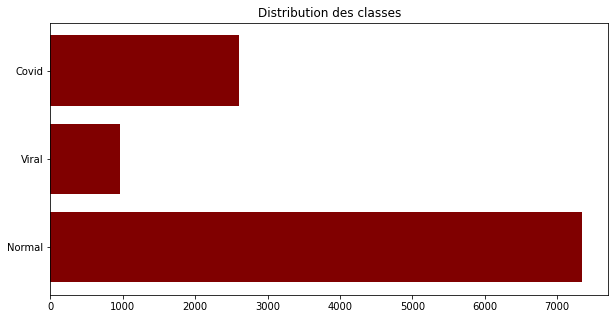

In [ ]:
dist = {}
quant = {}
        
for class_name in class_names:
    quant[class_name] = [x for x in os.listdir(train_dirs[class_name]) if x[-3:].lower().endswith('png')]
    dist[class_name.replace('_', ' ').capitalize()] = len(quant[class_name])

courses = list(dist.keys())
values = list(dist.values())
  
fig = plt.figure(figsize=(10, 5))
plt.barh(courses, values, color='maroon')

plt.title("Distribution des classes")
plt.show()

# Visualisation des données

In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels):
    plt.figure(figsize=(10,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.tight_layout()
    plt.show()

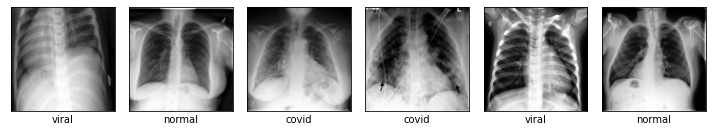

In [ ]:
images, labels = next(iter(dl_train))
images = images[:6]

show_images(images, labels)

# Création du modèle basique

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__() # 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, padding=3, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3, bias=False)
        self.bn3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(in_features=256, out_features=3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=7, stride=2) 
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=7, stride=2) 
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=7, stride=2) 

        x = F.adaptive_avg_pool2d(x, 1)                                            
        x = torch.flatten(x, 1)                                                    
        
        x = self.fc1(x)
        return x

In [ ]:
cnn_model = MyModel()
cnn_model.cuda()
cnn_model = cnn_model.to(device)
summary(cnn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3        [-1, 128, 109, 109]         401,408
       BatchNorm2d-4        [-1, 128, 109, 109]             256
            Conv2d-5          [-1, 256, 52, 52]       1,605,632
       BatchNorm2d-6          [-1, 256, 52, 52]             512
            Linear-7                    [-1, 3]             771
Total params: 2,018,115
Trainable params: 2,018,115
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 82.77
Params size (MB): 7.70
Estimated Total Size (MB): 91.04
----------------------------------------------------------------


# Fonctions d'entrainement et d'évaluation

In [ ]:
def trainer(model, train_loader, val_loader = None, epochs=25, checkpoint_file=None):
  
    loss_func = nn.CrossEntropyLoss()
    score_funcs = {'Accuracy': metrics.accuracy_score} 
    device = device
    
    to_track = ["Epochs", "Time", "Train_Loss"]
    if val_loader is not None:
        to_track.append("Val_Loss")
    for eval_score in score_funcs:
        to_track.append("Train_" + eval_score )
        if val_loader is not None:
            to_track.append("Val_" + eval_score )
        
    total_train_time = 0  
    results = {}
    
    for item in to_track:
        results[item] = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
             
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

          
            optimizer.zero_grad()

            y_hat = model(inputs) 

            
            loss = loss_func(y_hat, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])

        end = time.time()
        total_train_time += (end-start)
        
        results["Epochs"].append( epoch+1 )
        results["Time"].append( str(datetime.timedelta(seconds = total_train_time)) )
        results["Train_Loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: 
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["Train_" + name].append( score_func(y_true, y_pred) * 100)
      
        if val_loader is None:
            pass
        else:
            model = model.eval()

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                running_loss += loss.item() * inputs.size(0)

                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["Val_Loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1:
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["Val_" + name].append( score_func(y_true, y_pred) * 100)
                
        if checkpoint_file is not None:
            torch.save({
                'Epochs': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def evaluator(model,pred_label,true_label,ps_label,dataset,correct,total,accuracy):
    with torch.no_grad():
        for images, labels in dataset:
            model.eval()
            output = model(images.to(device))
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output), 1)[1]).detach().cpu().numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

# Création du modèle ResNet18

In [ ]:
resnet18_model = torchvision.models.resnet18(pretrained=True)
resnet18_model.fc = torch.nn.Linear(in_features=512, out_features=3)
resnet18_model.cuda()
summary(resnet18_model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Entrainement du modèle ResNet18

In [ ]:
resnet18_results = trainer(resnet18_model, dl_train, val_loader=dl_val, score_funcs={'Accuracy': metrics.accuracy_score}, device=device, epochs=25)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/171 [00:00<?, ?it/s]

# Résultats de l'entrainement du modèle ResNet18

In [ ]:
resnet18_results

,Epochs,Time,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy
0,1,0:02:10.417666,2240.819576,131.124794,92.558651,95.230263
1,2,0:04:23.416411,571.621797,92.216642,98.634531,96.875000
2,3,0:06:32.794027,364.836858,97.504968,98.918622,98.190789
3,4,0:08:42.664074,240.720923,58.312598,99.395161,98.026316
4,5,0:10:53.273412,133.462245,83.265695,99.734238,98.684211
5,6,0:13:05.269695,94.895189,90.846761,99.816716,97.697368
6,7,0:15:16.323597,72.865136,78.098056,99.844208,98.519737
7,8,0:17:26.721750,64.232801,70.193592,99.926686,97.532895
8,9,0:19:38.324814,46.838166,84.500376,99.880865,98.355263
9,10,0:21:49.514170,42.866687,91.052903,99.926686,98.355263


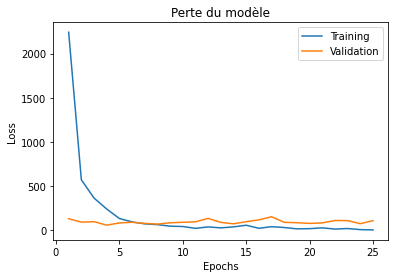

In [ ]:
sns.lineplot(x='Epochs', y='Train_Loss', data=resnet18_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Loss', data=resnet18_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Perte du modèle")
plt.show()

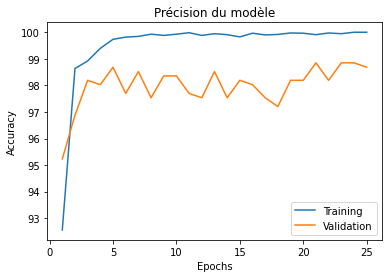

In [ ]:
sns.lineplot(x='Epochs', y='Train_Accuracy', data=resnet18_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Accuracy', data=resnet18_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Précision du modèle")
plt.show()

# Évaluation du modèle ResNet18

In [ ]:
test_pred_labels = []
test_true_labels = []
ps_list = []
running_correct = 0.0
running_total = 0.0
accuracy_test=0.0

resnet18_evaluation = evaluator(resnet18_model,test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

In [ ]:
print("Total Correct Images: {} | Total Test Images: {}".format(int(resnet18_evaluation[4]), int(resnet18_evaluation[5])))
print("Test Accuracy: ", resnet18_evaluation[6]*100)

Total Correct Images: 2990 | Total Test Images: 3030
Test Accuracy:  98.67986798679867


In [ ]:
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(resnet18_evaluation[1], resnet18_evaluation[0],target_names=class_names)))

Classification report for test set:
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98      1048
   PNEUMONIE       1.00      0.97      0.99       988
    COVID-19       0.99      0.99      0.99       994

    accuracy                           0.99      3030
   macro avg       0.99      0.99      0.99      3030
weighted avg       0.99      0.99      0.99      3030




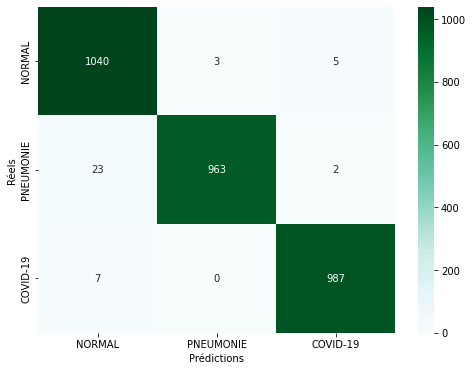

In [ ]:
arr = metrics.confusion_matrix(test_true_labels, test_pred_labels)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prédictions")
plt.ylabel("Réels")
plt.show()